In [4]:
from __future__ import print_function, division, absolute_import
import os
import sys
sys.path.insert(0, "C:\\Users\\Matt\\Desktop\\orbithunter\\")
from orbithunter import *
import numpy as np
# from scipy.fft import irfft,rfft,rfftn,irfftn,fftn,ifftn,fft,ifft,fft2,rfft2
import itertools
from math import pi
# from orbithunter.glue import *
import matplotlib.pyplot as plt
from scipy.fft import rfft, irfft
%matplotlib inline

In [42]:
dft_mat = rfft(np.eye(32), norm='ortho', axis=0)
time_dft_mat = np.concatenate((dft_mat[:-1, :].real,
                               dft_mat[1:-1, :].imag), axis=0)
ab_time_dft_mat = np.insert(time_dft_mat,
                            np.arange(time_dft_mat.shape[1]),
                            np.zeros([time_dft_mat.shape[0], time_dft_mat.shape[1]]),
                            axis=1)

In [50]:
np.sum(time_dft_mat[0]*rpo_test.state[0,:]

ValueError: operands could not be broadcast together with shapes (32,) (30,) 

In [53]:
ab_time_dft_mat.shape

(31, 64)

In [51]:
time_dft_mat.shape

(31, 32)

In [44]:
ab_time_dft_mat.shape

(31, 64)

In [3]:
os.getcwd()

'C:\\Users\\Matt\\Desktop\\orbithunter\\notebooks'

In [8]:
reqva_test = read_h5('reqva_L27p39.h5', directory='data')

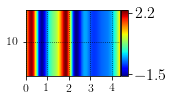

In [9]:
reqva_test.plot(fundamental_domain=False)

In [10]:
spacetime_modes = (1./np.sqrt(32)) * self.state

NameError: name 'self' is not defined

In [11]:
np.sum((1./np.sqrt(32)) * np.concatenate((0*np.eye(15), np.eye(15)), axis=1),axis=1)

array([0.1767767, 0.1767767, 0.1767767, 0.1767767, 0.1767767, 0.1767767,
       0.1767767, 0.1767767, 0.1767767, 0.1767767, 0.1767767, 0.1767767,
       0.1767767, 0.1767767, 0.1767767])

In [12]:
dft_mat = rfft(np.eye(32), norm='ortho', axis=0)
time_idft_mat = np.concatenate((dft_mat[:-1, :].real,
                                        dft_mat[1:-1, :].imag), axis=0)
time_idft_mat

array([[ 0.1767767 ,  0.1767767 ,  0.1767767 ,  0.1767767 ,  0.1767767 ,
         0.1767767 ,  0.1767767 ,  0.1767767 ,  0.1767767 ,  0.1767767 ,
         0.1767767 ,  0.1767767 ,  0.1767767 ,  0.1767767 ,  0.1767767 ,
         0.1767767 ,  0.1767767 ,  0.1767767 ,  0.1767767 ,  0.1767767 ,
         0.1767767 ,  0.1767767 ,  0.1767767 ,  0.1767767 ,  0.1767767 ,
         0.1767767 ,  0.1767767 ,  0.1767767 ,  0.1767767 ,  0.1767767 ,
         0.1767767 ,  0.1767767 ],
       [ 0.1767767 ,  0.17337998,  0.16332037,  0.14698445,  0.125     ,
         0.09821187,  0.06764951,  0.03448742,  0.        , -0.03448742,
        -0.06764951, -0.09821187, -0.125     , -0.14698445, -0.16332037,
        -0.17337998, -0.1767767 , -0.17337998, -0.16332037, -0.14698445,
        -0.125     , -0.09821187, -0.06764951, -0.03448742,  0.        ,
         0.03448742,  0.06764951,  0.09821187,  0.125     ,  0.14698445,
         0.16332037,  0.17337998],
       [ 0.1767767 ,  0.16332037,  0.125     ,  0.0676

In [57]:
rpo_test = reqva_test.copy()

rpo_test.convert(to='s_modes', inplace=True)
rpo_test.state = np.tile(reqva_test.convert(to='s_modes').state[-1,:].reshape(1,-1),(32,1))
smode0 = rpo_test.state[0,0]
rpo_test.convert(to='modes', inplace=True)

RelativeOrbitKS()

The transformation from s_modes to modes should result in division by np.sqrt(32). So what the fuck is going on. 

In [60]:
rpo_test.state[0,0], smode0

(2.0081617017736693, 0.06275505318042716)

In [63]:
(1/np.sqrt(32)) * smode0

0.06275505318042716

In [65]:
dft_mat = rfft(np.eye(32), norm='ortho', axis=0)
time_dft_mat = np.concatenate((dft_mat[:-1, :].real,
                               dft_mat[1:-1, :].imag), axis=0)
ab_time_dft_mat = np.insert(time_dft_mat,
                            np.arange(time_dft_mat.shape[1]),
                            np.zeros([time_dft_mat.shape[0], time_dft_mat.shape[1]]),
                            axis=1)
ab_time_dft_mat.shape

(31, 64)

In [69]:
np.sqrt(32)

5.656854249492381

In [68]:
rfft(np.ones(32), norm='ortho')

array([5.65685425+0.j, 0.        +0.j, 0.        -0.j, 0.        +0.j,
       0.        +0.j, 0.        +0.j, 0.        +0.j, 0.        +0.j,
       0.        -0.j, 0.        +0.j, 0.        +0.j, 0.        +0.j,
       0.        +0.j, 0.        +0.j, 0.        +0.j, 0.        +0.j,
       0.        +0.j])

In [47]:
reqva_test.convert(to='s_modes').state[-1,0]

0.35499618926081977

In [53]:
rpo_test.time_transform_matrix()*np.sqrt(32)

array([[1.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.19509032, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.19509032,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.19509032]])

In [63]:
?OrbitKS

In [66]:
1/np.sqrt(32)

0.17677669529663687

In [74]:
rfft(np.eye(32), norm='ortho', axis=0).shape

(17, 32)

In [78]:
(irfft(np.eye(17), norm='ortho', axis=0)[0,0])

0.17677669529663687

In [67]:
rfft(np.eye(32), norm='ortho', axis=0)[0,:]

array([0.1767767+0.j, 0.1767767+0.j, 0.1767767+0.j, 0.1767767+0.j,
       0.1767767+0.j, 0.1767767+0.j, 0.1767767+0.j, 0.1767767+0.j,
       0.1767767+0.j, 0.1767767+0.j, 0.1767767+0.j, 0.1767767+0.j,
       0.1767767+0.j, 0.1767767+0.j, 0.1767767+0.j, 0.1767767+0.j,
       0.1767767+0.j, 0.1767767+0.j, 0.1767767+0.j, 0.1767767+0.j,
       0.1767767+0.j, 0.1767767+0.j, 0.1767767+0.j, 0.1767767+0.j,
       0.1767767+0.j, 0.1767767+0.j, 0.1767767+0.j, 0.1767767+0.j,
       0.1767767+0.j, 0.1767767+0.j, 0.1767767+0.j, 0.1767767+0.j])

The relation between the magnitude of the modes and magnitude of the s_modes is 

In [58]:
reqva_test.convert(to='s_modes').state[-1,0]

0.35499618926081977

In [57]:
reqva_test.convert(to='s_modes').state[-1,0]/rpo_test.state[0,0]

0.17677669529663692

In [56]:
np.sqrt(32)

5.656854249492381

In [59]:
rpo_test.state[0,0]

2.0081617017736693

In [ ]:
rpo_test.state = 

In [24]:
reqva_test.convert(to='modes').state[:,0]

array([ 2.00816119e+00,  2.12374323e-07,  1.97795310e-08, -7.61809146e-09,
       -1.78098447e-09,  3.09109288e-10, -5.04663506e-10, -3.73551202e-11,
        3.33954741e-11,  4.11183681e-13, -6.20790847e-13, -7.69899452e-14,
        2.13722472e-14,  6.36851860e-15, -3.83799444e-15, -6.38692886e-17,
        1.82998871e-07, -2.24623804e-10,  7.59125075e-10,  1.07905079e-09,
       -2.28407107e-10, -2.42941782e-10,  1.04605826e-10,  5.53174975e-12,
       -4.45126172e-12, -2.02635542e-13,  1.44882733e-13,  3.55259405e-14,
       -1.49576949e-14,  8.70273644e-17,  1.56684170e-16])

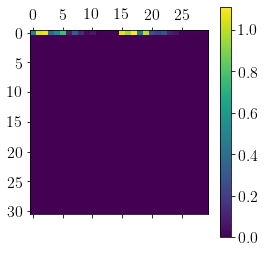

In [20]:
plt.matshow(np.log10(np.abs(reqva_test.convert(to='modes').state)+1))
plt.colorbar()

In [12]:
AntisymmetricOrbitKS(state=None)

Incompatible type provided for field or modes: 2-D NumPy arrays only


AntisymmetricOrbitKS()

In [4]:
ShiftReflectionOrbitKS()

Incompatible type provided for field or modes: 2-D NumPy arrays only


ShiftReflectionOrbitKS()

In [ ]:
# atorus = 
# torus = 
# a = read_h5("C:\\Users\\Matt\\Desktop\\orbithunter_test_data\\anti_L17p5_T17.h5")
# defect0 = read_h5("C:\\Users\\Matt\\Desktop\\orbithunter_test_data\\rpo_L12p87_T26.h5")
o2 = read_h5("C:\\Users\\Matt\\Desktop\\orbithunter_test_data\\full_L26.7_T54.h5")
# defect = read_h5("C:\\Users\\Matt\\Desktop\\orbithunter_test_data\\rpo_L13p02_T15.h5")
# sr = read_h5("C:\\Users\\Matt\\Desktop\\orbithunter_test_data\\ppo_L34p09_T23p18.h5")
# e = read_h5("C:\\Users\\Matt\\Desktop\\orbithunter_test_data\\eqva_L3p195.h5")
srtest = read_h5("C:\\Users\\Matt\\Desktop\\orbithunter_test_data\\rpo_L22p01_T85p99.h5")



In [ ]:
srtest.plot(fundamental_domain=False)

srtest.S

srtest.reflection().plot(fundamental_domain=False)

srtest_refl = srtest.reflection()

sr_srrefl_state = np.concatenate((srtest_refl.state, srtest.state))

test_orbit = ShiftReflectionOrbitKS(state=sr_srrefl_state,statetype='field',T=2*srtest.T,L=srtest.L)

test_orbit.plot(fundamental_domain=False)

In [ ]:
test_orbit.time_transform_matrix().shape

In [ ]:
np.dot(test_orbit.time_transform_matrix(), test_orbit.time_inv_transform_matrix()).shape#.sum(axis=1).sum()

In [ ]:
test_orbit.time_transform_matrix()

In [ ]:
test_orbit_result = converge(test_orbit, method='lstsq', verbose=True)

In [ ]:
o2 = read_h5("C:\\Users\\Matt\\Desktop\\orbithunter_test_data\\full_L26.7_T54.h5")
a2 = AntisymmetricOrbit(state=np.roll(o2.state, 6 ,axis=1), statetype=o2.statetype, T=o2.T, L=o2.L)
a2result = converge(a2, verbose=True)
a3 = a2result.orbit.convert(to='field')
o3 = Orbit(state=np.roll(a3.state, 6 ,axis=1), statetype=a3.statetype, T=a3.T, L=a3.L)
o3result = converge(o3, fixedparams=(False, True, False), verbose=True)
o4 = o3result.orbit.convert(to='field')
o4 = Orbit(state=np.roll(o4.state, 6 ,axis=1), statetype=o4.statetype, T=o4.T, L=o4.L)
o4result = converge(o4, fixedparams=(False, True, False), verbose=True)

In [ ]:
a2 = AntisymmetricOrbit(state=np.roll(o2.state, 6 ,axis=1), statetype=o2.statetype, T=o2.T, L=o2.L)

In [ ]:
o3result.orbit.L

In [ ]:
a3.L

In [ ]:
o3result.orbit.L

In [ ]:
a3.L-0.01

In [ ]:
o2.plot(fundamental_domain=False)

In [ ]:
defect.S

In [ ]:
defect.to_fundamental_domain().plot(fundamental_domain=False)

In [ ]:
defect.to_fundamental_domain().calculate_shift()

In [ ]:
defect.plot()

In [ ]:
defect2 = RelativeOrbit(state=defect.state, T=defect.T, L=defect.L, S=-1.0*defect.to_fundamental_domain().calculate_shift())
defect2 = defect2.to_fundamental_domain()

In [ ]:
defect2.S = defect.S+defect2.S

In [ ]:
defect2.S 

In [ ]:
defect2.plot(padding=False, fundamental_domain=False)

In [ ]:
result = converge(defect2, verbose=True)

In [ ]:
result.orbit.S

In [ ]:
result.orbit.plot(fundamental_domain=False)

In [ ]:
fig = plt.figure(figsize=(20,20))
plt.imshow(np.tile(result.orbit.state, (32,32)),cmap='jet',aspect='auto')

In [ ]:
defect = read_h5("C:\\Users\\Matt\\Desktop\\orbithunter_test_data\\rpo_L13p02_T15.h5")

In [ ]:
defect0 = read_h5("C:\\Users\\Matt\\Desktop\\orbithunter_test_data\\rpo_L12p87_T26.h5")
defect0.S *=-1

In [ ]:
defect0.residual()

In [ ]:
defect.S

In [ ]:
defect.plot(fundamental_domain=False)

In [ ]:
exit_code = 1
result = converge(defect2, fixedparams=(False, False, False), verbose=True)
defect_down = result.orbit

while exit_code == 1:
    # print(wiggle_freeboundary.residual())
    defect_down.L -= 0.01
    # print(wiggle_freeboundary.residual())
    result = converge(defect_down, fixedparams=(False, True, False), verbose=True)
    exit_code = result.exit_code
    if exit_code == 1:
        defect_down = result.orbit
        print(result.orbit.state_vector()[-3:])
        defect_down.plot()
defect_down.plot()

In [ ]:
exit_code = 1
result = converge(defect, fixedparams=(False, False, True), verbose=True)
defect_down = result.orbit

while exit_code == 1:
    # print(wiggle_freeboundary.residual())
    defect_down.S += 2
    # print(wiggle_freeboundary.residual())
    result = converge(defect_down, method='lstsq', fixedparams=(False,False,False), verbose=True)
    exit_code = result.exit_code
    if exit_code == 1:
        defect_down = result.orbit
        print(result.orbit.state_vector()[-3:])
        defect_down.plot(fundamental_domain=False)
defect_down.plot(fundamental_domain=False)

In [ ]:
fig = plt.figure(figsize=(20,20))
plt.imshow(np.tile(defect.state, (32,32)),cmap='jet',aspect='auto')

In [ ]:
exit_code = 1
result = converge(defect_down, fixedparams=(False, False, False), verbose=True)
defect_down = result.torus

while exit_code == 1:
    # print(wiggle_freeboundary.residual())
    defect_down.L -= 0.01
    # print(wiggle_freeboundary.residual())
    result = converge(defect_down, method='lstsq', fixedparams=(False,True,False), verbose=True)
    exit_code = result.exit_code
    if exit_code == 1:
        defect_down = result.torus
        print(result.torus.L)
        defect_down.plot()
defect_down.plot()

In [ ]:
# defect = rediscretize(defect, newN=32, newM=32)#.to_fundamental_domain()
# result = converge(defect, fixedparams=(False, False, False), verbose=True)
# defect = result.torus

In [ ]:
defect.S

In [ ]:
defect.plot()

In [ ]:


defect_down = RelativeTorus(state=defect.convert(to='field').state, statetype='field', T=defect.T, L=defect.L, S=defect.S)
exit_code = 1
result = converge(defect_down, fixedparams=(False, False, False), verbose=True)
defect_down = result.torus

while exit_code == 1:
    # print(wiggle_freeboundary.residual())
    defect_down.L -= 0.01
    # print(wiggle_freeboundary.residual())
    result = converge(defect_down,  fixedparams=(False,True,False), verbose=True)
    exit_code = result.exit_code
    if exit_code == 1:
        defect_down = result.torus
        defect_down.plot(save=True)
defect_down.plot(save=True)

In [ ]:
defect_up = RelativeTorus(state=defect.convert(to='field').state, statetype='field', T=defect.T, L=defect.L, S=defect.S)
exit_code = 1
result = converge(defect_up, fixedparams=(False, False, False), verbose=True)
defect_up = result.torus

while exit_code == 1:
    defect_up.L += 2
    print(defect_up.L)
    result = converge(defect_up,  fixedparams=(False,False,False), verbose=True)
    exit_code = result.exit_code
    if exit_code == 1:
        defect_up = result.torus
        print(result.torus.L)
        defect_up.plot()
defect_up.plot()

In [ ]:
result = converge(rediscretize(a, newN=32, newM=32), fixedparams=(False, False, False), verbose=True)
wiggle = result.torus

In [ ]:
wiggle.plot()

In [ ]:
wiggle_up = Torus(state=wiggle.convert(to='field').state, statetype='field', T=wiggle.T, L=wiggle.L)
exit_code = 1

In [ ]:
wiggle_up.N

In [ ]:
niter=0
while exit_code == 1:
    wiggle_up.L += 0.01
    result = converge(wiggle_up, method='lstsq', fixedparams=(False, True, False), verbose=False)
    exit_code = result.exit_code
    
    if exit_code == 1:
        niter+=1
        wiggle_up = result.torus
        print(result.torus.L)
        if niter % 5 == 0:
            wiggle_up.plot()
        # wiggle_freeboundary.plot()
wiggle_up.plot()

In [ ]:
wiggle_up = Torus(state=wiggle.convert(to='field').state, statetype='field', T=wiggle.T, L=wiggle.L)
exit_code = 1

In [ ]:
while exit_code == 1:
    # print(wiggle_freeboundary.residual())
    wiggle_up.L += 0.5
    # print(wiggle_freeboundary.residual())
    result = converge(wiggle_up, verbose=True)
    exit_code = result.exit_code
    if exit_code == 1:
        wiggle_up = result.torus
        print(result.torus.L)
        wiggle_up.plot()
        
print(result.torus.L)
wiggle_up.plot()

In [ ]:
result = converge(wiggle, fixedparams=(False, True, False), verbose=True)
wiggle = result.torus

In [ ]:
wiggle_freeboundary = RelativeTorus(state=wiggle.state, statetype=wiggle.statetype, T=wiggle.T, L=wiggle.L, S=0)
exit_code = 1

wiggle_freeboundary.S = float(wiggle_freeboundary.calculate_shift())



while exit_code == 1:
    wiggle_freeboundary.L -= 0.01
    result = converge(wiggle_freeboundary, fixedparams=(False, True, False), verbose=True)
    exit_code = result.exit_code
    print(exit_code, result.torus.L)
    if exit_code == 1:
        wiggle_freeboundary = result.torus

In [ ]:
# defect_down = rediscretize(r, newN=32, newM=32)#.to_fundamental_domain()
defect_down = defect
# defect = RelativeTorus(state=wiggle.state, statetype=wiggle.statetype, T=wiggle.T, L=wiggle.L, S=0)
exit_code = 1
# wiggle_freeboundary.S = float(wiggle_freeboundary.calculate_shift())

while exit_code == 1:
    defect_down.L -= 0.1
    result = converge(defect_down, method='lstsq', fixedparams=(False, True, False),  verbose=True)
    exit_code = result.exit_code
    if exit_code == 1:
        defect_down = result.torus

In [ ]:
defect_up = rediscretize(r, newN=32, newM=32)#.to_fundamental_domain()
# wiggle_freeboundary = RelativeTorus(state=wiggle.state, statetype=wiggle.statetype, T=wiggle.T, L=wiggle.L, S=0)
exit_code = 1
while exit_code == 1:
    defect_down.L += 0.1
    result = converge(defect_down, fixedparams=(False, False, False),  verbose=True)
    exit_code = result.exit_code
    if exit_code == 1:
        defect_down = result.torus

In [ ]:
result

In [ ]:
result = converge(wiggle_freeboundary, fixedparams=(False, True, False), method='lstsq', verbose=True)


In [ ]:
wiggle_freeboundary.plot(fundamental_domain=False)

In [ ]:
def draw_nodal_lines(orbit, epsilon=0.2):
    orbit_dx_field = orbit.dx().convert(to='field').state
    nodal = np.where(np.abs(orbit_dx_field)< epsilon) 
    not_nodal = np.where(np.abs(orbit_dx_field) >= epsilon)
    orbit_dx_field[nodal]=1
    orbit_dx_field[not_nodal]=None
    
    return orbit_dx_field

In [ ]:
# anew = rediscretize(a, newN=256, newM=256)
# rnew = rediscretize(r, newN=256, newM=256)
# enew = rediscretize(e, newN=256, newM=256)
# anew.plot(fundamental_domain=False, padding=False)
# rnew.comoving_transformation().plot(fundamental_domain=False, padding=False)

In [ ]:
rnode = draw_nodal_lines(rnew.to_fundamental_domain(), epsilon=0.1)
rnode_halfcell = np.roll(rnode, rnode.shape[1]//2, axis=1)

fig = plt.figure()
plt.imshow(rnode, origin='lower')
_ = plt.show()

fig = plt.figure()
plt.imshow(rnode_halfcell, origin='lower')
_ = plt.show()

In [ ]:
wiggle_freeboundary

In [ ]:
anode = draw_nodal_lines(anew, epsilon=0.1)
anode_halfcell = np.roll(anode, anode.shape[1]//2, axis=1)

fig = plt.figure()
plt.imshow(anode, origin='lower')
_ = plt.show()

fig = plt.figure()
plt.imshow(anode_halfcell, origin='lower')
_ = plt.show()

In [ ]:
fig = plt.figure()
plt.imshow(draw_nodal_lines(rediscretize(a, newN=256, newM=256)))
_ = plt.show()

In [ ]:
Torus(state=draw_nodal_lines(a), statetype='field',

In [ ]:
e.convert(to='field').state.shape

In [ ]:
e.convert(to='modes').state.shape

In [ ]:
converge(e)

In [ ]:
e.N

In [ ]:
padding = np.zeros([e.state.shape[0], 32])
eqv_modes = e.convert(to='modes').state
padded_modes = np.concatenate((eqv_modes, padding), axis=1)

In [ ]:
padded_modes.shape

In [ ]:
e.convert(to='modes').state

In [ ]:
e.convert(to='field').state.shape

In [ ]:
e3 = rediscretize(e.convert(to='field'), newN=32, newM=32)

In [ ]:
e3.state.shape

In [ ]:
erd = rediscretize(e.convert(to='field'), newN=a.N+2, newM=a.M+2)

In [ ]:
ard = rediscretize(a.convert(to='field'), newN=a.N+2, newM=a.M+2)

In [ ]:
ord_ = rediscretize(o.convert(to='field'), newN=o.N+2, newM=o.M+2)
ord_ = rediscretize(o.convert(to='field'), newN=o.N-2, newM=o.M-2)

In [ ]:
ord_.plot()

In [ ]:
o2rd = rediscretize(o2.convert(to='field'), newN=o2.N+2, newM=o2.M+2)
o2rd_ = rediscretize(o2.convert(to='field'), newN=o2.N-2, newM=o2.M-2)

In [ ]:
rrd = rediscretize(r.convert(to='field'), newN=r.N+2, newM=r.M+2)
rrd = rediscretize(r.convert(to='field'), newN=r.N-2, newM=r.M-2)

In [ ]:
srrd = rediscretize(sr.convert(to='field'), newN=sr.N+2, newM=sr.M+2)
srrd = rediscretize(sr.convert(to='field'), newN=sr.N-2, newM=sr.M-2)

In [ ]:
erd = rediscretize(e.convert(to='field'), newN=e.N+2, newM=e.M+2)
erd = rediscretize(e.convert(to='field'), newN=e.N-2, newM=e.M-2)

In [ ]:
a_result = converge(ard, verbose=True)
a_result

In [ ]:
a_result.torus.plot()

In [ ]:
o_result = converge(ord_, verbose=True)
o_result

In [ ]:
o_result.torus.plot()

In [ ]:
ord_.mode_shape

In [ ]:
ord_.plot()

In [ ]:
o2_result = converge(o2rd, verbose=True)
o2_result

In [ ]:
o2_result.torus.plot()

In [ ]:
o2_result = converge(o2, atol=10**-14, verbose=True)
o2_result

In [ ]:
o2_result.torus.plot()

In [ ]:
r_result = converge(rrd, verbose=True)
r_result

In [ ]:
r_result.torus.plot()

In [ ]:
sr_result = converge(srrd, verbose=True)
sr_result

In [ ]:
sr_result.torus.plot()

In [ ]:
e.elementwise_dx()

In [ ]:
e.wave_vector().shape

In [ ]:
e.m

In [ ]:
torus = read_h5("C:\\Users\\Matt\\Desktop\\full_L26.7_T54.h5")
torus.state = np.roll(torus.state,6,axis=1)
torus.plot(fundamental_domain=False)

In [ ]:
x0 = AntisymmetricTorus(state=torus.state, statetype=torus.statetype, L=torus.L, T=torus.T)

In [ ]:
xfr = converge(x0, method='lstsq')
xf = xfr.torus

In [ ]:
xf.residual()

In [ ]:
xf.plot(fundamental_domain=False)

In [ ]:
# x0 = rediscretize(xf.convert(to='field'), newN=16, newM=32)
x = ShiftReflectionTorus(state=np.roll(xf.convert(to='field').state,7,axis=1), statetype='field',T=xf.T, L=xf.L) 

In [ ]:
x.residual()

In [ ]:
x.plot(fundamental_domain=False)

In [ ]:
xf_result = converge(x, atol=10**-14, max_iter=10000, verbose=True)

In [ ]:
xf_result.torus.residual()

In [ ]:
xf_result.torus.state

In [ ]:
xf_result = converge(xfa, method='lstsq', atol=10**-14, verbose=True)

In [ ]:
ppotorus.plot()

In [ ]:
ppotorus.residual()

In [ ]:
xf_result = converge(ppotorus, method='lstsq',atol=10**-14, verbose=True)

In [ ]:
xf_result.torus.residual()

In [ ]:
xf_result.torus.plot()

In [ ]:
xf_result.torus.statetype

In [ ]:
x0 = xf_result.torus.convert(to='field')
x = Torus(state=x0.state,statetype='field',T=x0.T, L=x0.L) 

In [ ]:
x.plot()

In [ ]:
x.residual()

In [ ]:
xf_result = converge(x, method='lstsq',atol=10**-14, verbose=True)

In [ ]:
xf_result.torus.plot()

In [ ]:
xf = converge(x,method='adj',atol=10**-14, verbose=True)

In [ ]:
xff = converge(xf.torus, method='lstsq',atol=10**-14, verbose=True)

In [ ]:
xf.torus.residual()

In [ ]:
atorus = AntisymmetricTorus(state=torus.state, statetype='field', T=torus.T, L=torus.L)

In [ ]:
ppotorus = ShiftReflectionTorus(state=torus.state, statetype='field', T=torus.T, L=torus.L)

In [ ]:
a_old_vv = atorus.convert(to='modes').state

In [ ]:
u = torus.convert(to='field').state

In [ ]:
a_old_v = atorus.convert(to='s_modes').state
ppo_old_v = ppotorus.convert(to='s_modes').state
old_v = torus.convert(to='s_modes').state

In [ ]:
a_old_vv = atorus.convert(to='modes').state
ppo_old_vv = ppotorus.convert(to='modes').state
old_vv = torus.convert(to='modes').state

In [ ]:
space_modes = rfft(torus.convert(to='field').state, norm='ortho', axis=1)[:, 1:-1]
spatial_modes = np.concatenate((space_modes.real, space_modes.imag), axis=1)

In [ ]:
modes = rfft(spatial_modes, norm='ortho', axis=0)
modes_real = modes.real[:-1, -atorus.m:]
modes_imag = modes.imag[1:-1, -atorus.m:]
anti_spacetime_modes = np.concatenate((modes_real, modes_imag),axis=0)

In [ ]:
# PPO
modes = rfft(spatial_modes, norm='ortho', axis=0)
modes_real = modes.real[:-1, :-torus.m] + modes.real[:-1, -torus.m:]
modes_imag = modes.imag[1:-1, :-torus.m] + modes.imag[1:-1, -torus.m:]
ppo_spacetime_modes = np.concatenate((modes_real, modes_imag),axis=0)

In [ ]:
# Torus, RelativeTorus
modes = rfft(spatial_modes, norm='ortho', axis=0)
modes_real = modes.real[:-1, :] 
modes_imag = modes.imag[1:-1, :]
spacetime_modes = np.concatenate((modes_real, modes_imag),axis=0)

In [ ]:
mat_tmp = irfft(np.eye(torus.N//2+1), norm='ortho', axis=0)
time_irfft_mat = np.concatenate((mat_tmp[:,:-1], mat_tmp[:,1:-1]),axis=1)

In [ ]:
np.linalg.norm(f.transpose()-space_mat)

In [ ]:
self = torus
fx = (1 / np.sqrt(self.M)) * old_rfft(np.eye(self.M), axis=0)[1:self.M - 1, :]
fx_a = np.zeros([self.m, self.M], float)
fx_b = np.zeros([self.m, self.M], float)

indices = np.arange(0, self.m)
fx_a[indices, :] = fx[2 * indices, :]
fx_b[indices, :] = fx[2 * indices + 1, :]

ff = np.concatenate((fx_a, fx_b), axis=0)

In [ ]:
plt.imshow(f-space_mat)
_ = plt.show()

In [ ]:
space_real_mat = irfft(np.eye(torus.M//2 + 1), norm='ortho', axis=0)

space_imag_mat = irfft(1j*np.eye(torus.M//2 + 1), norm='ortho', axis=0)

space_mat = np.concatenate((space_real_mat[:, 1:-1], space_imag_mat[:, 1:-1]),axis=1)

space_ifft_matrix = np.kron(space_mat, np.eye(torus.N))

np.linalg.norm(space_ifft_matrix-torus.space_irfft_matrix())

In [ ]:
space_mat.shape

In [ ]:
np.eye(torus.M//2 + 1).shape

In [ ]:
irfft(np.eye(torus.M//2 + 1), norm='ortho', axis=0)

In [ ]:
fx = np.sqrt(self.M)*old_irfft(np.eye(self.M), axis=0)[:, 1:self.M-1]
fx_a = np.zeros([self.M, self.m], float)
fx_b = np.zeros([self.M, self.m], float)

indices = np.arange(0, self.m)
fx_a[:, indices] = fx[:, 2 * indices]
fx_b[:, indices] = fx[:, 2 * indices + 1]

fb = np.concatenate((fx_a, fx_b), axis=1)

In [ ]:
imag_idft_matrix = irfft(1j*np.eye((torus.N//2)+1), norm='ortho', axis=0)
real_idft_matrix = irfft(np.eye((torus.N//2)+1), norm='ortho', axis=0)
time_idft_matrix = np.concatenate((real_idft_matrix[:, :-1], imag_idft_matrix[:, 1:-1]),axis=1)
ab_time_idft_matrix = np.insert(time_idft_matrix, np.arange(time_idft_matrix.shape[0]), time_dft_matrix, axis=0)

ab_transform_formatter = np.zeros((2*torus.N, torus.N-1),dtype=int)
ab_transform_formatter[::2,1:-torus.n:2] = 1
ab_transform_formatter[1::2,:-torus.n:2] = 1
ab_transform_formatter[1::2,-torus.n+1::2] = 1
ab_transform_formatter[::2,-torus.n::2] = 1

full_time_ifft_matrix = np.kron(ab_time_idft_matrix*ab_transform_formatter, 
                                np.eye(torus.mode_shape[1]))

In [ ]:
ab_transform_formatter = np.zeros((torus.N-1, 2*torus.N),dtype=int)
#odd rows
ab_transform_formatter[1:-torus.n:2,::2] = 1
ab_transform_formatter[:-torus.n:2,1::2] = 1
ab_transform_formatter[-torus.n+1::2,1::2] = 1
ab_transform_formatter[-torus.n::2, ::2] = 1

full_dft_mat = rfft(np.eye(torus.M), norm='ortho', axis=0)
# time_real_mat = rfft(np.eye(torus.N//2+1), norm='ortho', axis=0)
time_dft_mat = np.concatenate((full_dft_mat[:-1, :].real, full_dft_mat[1:-1, :].imag), axis=0)
ab_time_dft_matrix = np.insert(time_dft_mat, np.arange(time_dft_mat.shape[1]), time_dft_mat, axis=1)
full_time_fft_matrix = np.kron(ab_time_dft_matrix*ab_transform_formatter, np.eye(torus.m))

In [ ]:
idft_mat = irfft(np.eye(torus.N//2 + 1), norm='ortho', axis=0)
time_idft_mat = np.concatenate((idft_mat[:, :-1].real, 
                                idft_mat[:, 1:-1].imag), axis=1)

In [ ]:
torus.dt_matrix().shape

In [ ]:
torus.dx_matrix(order=2).shape

In [ ]:
%%timeit
torus.dt_matrix() + torus.dx_matrix(order=2, statetype='modes') + torus.dx_matrix(order=4, statetype='modes')

In [ ]:
%%timeit
qk=torus.wave_vector().ravel()
dx2 = -1*np.kron(np.eye(torus.N-1), np.diag(qk**2))
dx4 = -1*np.kron(np.eye(torus.N-1), np.diag(qk**4))
jl = torus.dt_matrix() + dx2 + dx4

In [ ]:
idft_mat = irfft(np.eye(torus.M//2 + 1), norm='ortho', axis=0)[:, 1:-1]
space_idft_mat = np.concatenate((idft_mat.real, idft_mat.imag), axis=1)
space_idft_mat.shape

In [ ]:
dft_mat = rfft(np.eye(torus.N), norm='ortho', axis=0)
time_dft_mat = np.concatenate((dft_mat[:-1,:].real, dft_mat[1:-1,:].imag), axis=0)
ab_time_dft_mat = np.insert(time_dft_mat, 
                             np.arange(time_dft_mat.shape[1]), 
                             np.zeros([time_dft_mat.shape[0], time_dft_mat.shape[1]]),
                             axis=1)
np.kron(ab_time_dft_mat, np.eye(torus.m)).shape

In [ ]:
plt.imshow(ab_time_idft_mat)
plt.colorbar()
_ = plt.show()

In [ ]:
ab_time_idft_mat.shape

In [ ]:
tttt = full_time_ifft_matrix[full_time_ifft_matrix!=0]
tttt[-5:]

In [ ]:
# tmptmp = time_test[:, np.newaxis, :]


In [ ]:
shuf2 = np.tile(np.insert(np.ones(8), np.arange(8), np.zeros(8)), (32,1))
shuf1 = np.tile(np.insert(np.zeros(8), np.arange(8), np.ones(8)), (32,1))
shuffle_mat = np.insert(shuf1.reshape(32, 1, 16), np.arange(32), shuf2.reshape(32,1,16),axis=0).squeeze()
t2 = np.concatenate((shuffle_mat, shuffle_mat[:,1:]),axis=1)*tst
# shufodd = np.roll(np.insert(shuf1.reshape(16, 1, 32), np.arange(16), shuf2.reshape(16,1,32),axis=0).squeeze(),1,axis=1)
# shufodd = shufodd[:,:-1]
# shufeven = shufeven[:,:-1]

In [ ]:
# %%timeit


In [ ]:
plt.imshow(tst)
plt.colorbar()
_ = plt.show()

In [ ]:
plt.imshow(t2)
plt.colorbar()
_ = plt.show()

In [ ]:
plt.imshow((tst*rangeifft)-t2)
_ = plt.colorbar()

In [ ]:
%%timeit
torus.time_irfft_matrix()

In [ ]:
%%timeit
rangefft = np.zeros((31, 64),dtype=int)
#odd rows
rangefft[1:-15:2,::2] = 1
rangefft[:-15:2,1::2] = 1
rangefft[-15+1::2,1::2] = 1
rangefft[-15::2, ::2] = 1
time_mat = rfft(np.eye(torus.M), norm='ortho', axis=0)
# time_real_mat = rfft(np.eye(torus.N//2+1), norm='ortho', axis=0)
time_forward = np.concatenate((time_mat[:-1, :].real, time_mat[1:-1, :].imag), axis=0)
time_mat_large = np.insert(time_forward, np.arange(time_forward.shape[1]), time_forward, axis=1)*rangefft
full_time_fft_matrix = np.kron(time_mat_large, np.eye(torus.m))
# np.linalg.norm(full_time_ifft_matrix-torus.time_ifft_matrix())

In [ ]:
%%timeit
rangefft = np.zeros((31, 64),dtype=int)
#odd rows
rangefft[1:-15:2,::2] = 1
rangefft[:-15:2,1::2] = 1
rangefft[-15+1::2,1::2] = 1
rangefft[-15::2, ::2] = 1

In [ ]:
%%timeit
shuf22 = np.tile(np.insert(np.ones(32), np.arange(32), np.zeros(32)).reshape(1, -1), (8, 1))
shuf12 = np.tile(np.insert(np.zeros(32), np.arange(32), np.ones(32)).reshape(1, -1), (8, 1))
shuffle_mat2 = np.insert(shuf12, np.arange(8), shuf22, axis=0)
shuf_final = np.concatenate((shuffle_mat2, shuffle_mat2[1:,:]), axis=0)

time_mat = rfft(np.eye(torus.M), norm='ortho', axis=0)
time_forward = np.concatenate((time_mat[:-1, :].real, time_mat[1:-1, :].imag), axis=0)
time_mat_large = np.insert(time_forward, np.arange(time_forward.shape[1]), time_forward, axis=1)*shuf_final
full_time_fft_matrix = np.kron(time_mat_large, np.eye(torus.m))

In [ ]:
plt.imshow(full_time_ifft_matrix)

In [ ]:
plt.imshow(torus.time_irfft_matrix()-full_time_ifft_matrix)

In [ ]:
rangefft = np.zeros((31, 64),dtype=int)
rangefft[1::2,::2] = 1
rangefft[::2,1::2] = 1

In [ ]:
%%timeit
rangefft = np.zeros((31, 64),dtype=int)
#odd rows
rangefft[1:-15:2,::2] = 1
rangefft[:-15:2,1::2] = 1
rangefft[-15+1::2,1::2] = 1
rangefft[-15::2, ::2] = 1
# rangefft[1:16:2,::2] = 1
# rangefft[:16:2,1::2] = 1
# rangefft[16::2,1::2] = 1
# rangefft[16::2, ::2] = 1

In [ ]:
%%timeit
rangefft = np.zeros((16, 64),dtype=int)
#odd rows
rangefft[1::2,::2] = 1
rangefft[::2,1::2] = 1
rangefft = np.concatenate((rangefft, rangefft[1:, :]),axis=0) 
# rangefft[1:16:2,::2] = 1
# rangefft[:16:2,1::2] = 1
# rangefft[16::2,1::2] = 1
# rangefft[16::2, ::2] = 1

In [ ]:
rangefft = np.zeros((16, 64),dtype=int)
#odd rows
rangefft[1::2,::2] = 1
rangefft[::2,1::2] = 1
rangefft = np.concatenate((rangefft, rangefft[1:, :]),axis=0) 
plt.imshow(rangefft)

In [ ]:
%%timeit


In [ ]:
shuf22 = np.tile(np.insert(np.ones(32), np.arange(32), np.zeros(32)).reshape(1, -1), (8, 1))
shuf12 = np.tile(np.insert(np.zeros(32), np.arange(32), np.ones(32)).reshape(1, -1), (8, 1))
shuffle_mat2 = np.insert(shuf12, np.arange(8), shuf22, axis=0)
shuf_final = np.concatenate((shuffle_mat2, shuffle_mat2[1:,:]), axis=0)

In [ ]:
plt.imshow(rangefft-shuf_final)

In [ ]:

# t3 = np.concatenate((shuffle_mat2, shuffle_mat2[1:,:]), axis=0)*time_mat_large

In [ ]:
plt.imshow(np.concatenate((shuffle_mat2, shuffle_mat2[1:,:]), axis=0))

In [ ]:
plt.imshow(np.concatenate((rangefft, rangefft[1:,:]), axis=0))

In [ ]:
np.linalg.norm(np.kron(t3, np.eye(ppotorus.m)).dot(ppotorus.convert(to='s_modes').state.ravel())-ppo_old_vv.ravel())

In [ ]:
full_time_fft_matrix.dot(ppotorus.convert(to='s_modes').state.ravel())

In [ ]:
np.linalg.norm(ppo_old_vv.ravel()-full_time_fft_matrix.dot(ppotorus.convert(to='s_modes').state.ravel()))

In [ ]:
full_time_fft_matrix.shape

In [ ]:
self = ppotorus
ft = np.sqrt(self.N) * old_irfft(np.eye(self.N), axis=0)[:, :-1]
indices = np.arange(0, self.n)
odd_freq = indices[np.where(~np.mod(indices, 2).astype(bool))]
even_freq = indices[np.where(np.mod(indices, 2).astype(bool))]

zero = ft[:, 0]
real = ft[:, 2 * indices + 1]
imaginary = ft[:, 2 * indices + 2]

even = np.concatenate((zero.reshape(-1, 1), real[:, even_freq], imaginary[:, even_freq]), axis=1)
odd = np.concatenate((real[:, odd_freq], imaginary[:, odd_freq]), axis=1)

even_staggered_rows = np.insert(even, np.arange(even.shape[0]), np.zeros([1, even.shape[1]]), axis=0)
odd_staggered_rows = np.insert(odd, np.arange(odd.shape[0])+1, np.zeros([1, odd.shape[1]]), axis=0)

# Adds a new-axis during the reshape operation
e3 = even_staggered_rows.reshape(even_staggered_rows.shape[0], even_staggered_rows.shape[1], 1)
o3 = odd_staggered_rows.reshape(odd_staggered_rows.shape[0], odd_staggered_rows.shape[1], 1)
shuffle_indices = np.concatenate((np.arange(o3.shape[1] // 2),
                                  ((o3.shape[1] // 2) + 1) + np.arange(o3.shape[1] // 2 - 1)), axis=0)
irfft_mat = np.squeeze(np.insert(o3, shuffle_indices, e3, axis=1))

In [ ]:
plt.imshow(ppotorus.time_irfft_matrix())

In [ ]:
%%timeit
even_indices = np.arange(0, torus.N//2, 2)
odd_indices = np.arange(1, torus.N//2, 2)
complex_spacetime = ppo_spacetime_modes[:-n, :]+1j*np.concatenate((np.zeros([1,torus.m]), ppo_spacetime_modes[-n:, :]),axis=0)
full_complex=np.concatenate((complex_spacetime,np.zeros([1,torus.m])),axis=0)
a, b = full_complex.copy(), full_complex.copy()
a[even_indices, :] = 0
b[odd_indices, :] = 0
irfft(np.concatenate((a,b), axis=1), norm='ortho',axis=0)

In [ ]:
torus = read_h5("C:\\Users\\Matt\\Desktop\\ppo_L21p99_T10p25.h5")

In [ ]:
x.convert(to='field', inplace=True)
np.random.seed(seed=0)
y = np.max(np.abs(x.state))*np.random.randn(32, 32)
noise_x = x.__class__(state=x.state + y, statetype='field', T=x.T, L=x.L, S=x.S)
noise_y = x.__class__(state=y, statetype='field', T=x.T, L=x.L, S=x.S)

In [ ]:
rediscretize(noise_x, newN=128, newM=128)

In [ ]:
plt.imshow(rediscretize(noise_x, newN=512, newM=512).state)

In [ ]:
fig, (ax0, ax1, ax2) = plt.subplots(1,3,figsize=(8,8))
ax0.imshow(rediscretize(x, newN=512, newM=512).convert(to='field').state, 
           cmap='jet', vmin=noise_x.state.min(), vmax=noise_x.state.max(),
           extent=[0, x.L/(2*pi), 0, x.T],aspect=0.25
          )
ax1.imshow(rediscretize(noise_y, newN=512, newM=512).convert(to='field').state,
           cmap='jet', vmin=noise_x.state.min(), vmax=noise_x.state.max(),
           extent=[0, x.L/(2*pi), 0, x.T],aspect=0.25
          )
im = ax2.imshow(rediscretize(noise_x, newN=512, newM=512).convert(to='field').state,
                cmap='jet', vmin=noise_x.state.min(), vmax=noise_x.state.max(),
           extent=[0, x.L/(2*pi), 0, x.T],aspect=0.25
               )

# fig.colorbar(im, ax=[ax0,ax1,ax2])
fig.subplots_adjust(right=0.8)
# put colorbar at desire position
cbar_ax = fig.add_axes([0.85, 0.35, 0.02, 0.29])
fig.colorbar(im, cax=cbar_ax)
_ = ax1.set_yticks([])
_ = ax2.set_yticks([])

In [ ]:
np.linalg.norm(x.state)

In [ ]:
noise_x.copy()

In [ ]:
final_result = converge(noise_x, method='hybrid', verbose=True)
final_result

In [ ]:
noise_y.state.max(), noise_y.state.min()

In [ ]:
noise_x_result = final_result.torus
noise_x_result = noise_x_result.convert(to='field')

In [ ]:
x.state.max(), x.state.min()

In [ ]:
noise_x_result.T, noise_x_result.L

In [ ]:
noise_x_result.plot(fundamental_domain=False)

In [ ]:
plt.rcParams.update({'font.size': 22})

In [ ]:
fig, (ax0, ax1, ax2, ax3) = plt.subplots(1,4,figsize=(20,20))
ax0.imshow(rediscretize(x, newN=512, newM=512).state, 
           cmap='jet', vmin=noise_x.state.min(), vmax=noise_x.state.max(),
           extent=[0, x.L/(2*pi), 0, x.T],aspect=0.25
          )
ax1.imshow(rediscretize(noise_y, newN=512, newM=512).state,
           cmap='jet', vmin=noise_x.state.min(), vmax=noise_x.state.max(),
           extent=[0, x.L/(2*pi), 0, x.T],aspect=0.25
          )
ax2.imshow(rediscretize(noise_x, newN=512, newM=512).state,
                cmap='jet', vmin=noise_x.state.min(), vmax=noise_x.state.max(),
           extent=[0, x.L/(2*pi), 0, x.T],aspect=0.25
               )
im = ax3.imshow(rediscretize(noise_x_result, newN=512, newM=512).state,
                cmap='jet', vmin=noise_x.state.min(), vmax=noise_x.state.max(),
           extent=[0, x.L/(2*pi), 0, x.T], aspect=0.25
               )

# fig.colorbar(im, ax=[ax0,ax1,ax2])
fig.subplots_adjust(right=0.8)
# put colorbar at desire position
cbar_ax = fig.add_axes([0.81, 0.395, 0.01, 0.214])
fig.colorbar(im, cax=cbar_ax)
ax0.set_yticks([0, 10, 20])
ax0.set_yticklabels([0, 10, 20])
_ = ax1.set_yticks([])
_ = ax2.set_yticks([])
_ = ax3.set_yticks([])
plt.savefig('MNG_noise.pdf', bbox_inches='tight', pad_inches=0)

In [ ]:
filename = 'C:\\Users\\Matt\\Desktop\\rpo_L13p02_T15.h5'

merger = read_h5(filename)

merger.plot()

merger.state.shape

In [ ]:
merger.residual()

In [ ]:
np.random.seed(seed=0)
test =  0.1*np.random.randn(32, 16)
merger.state = merger.state + test

In [ ]:
merger.residual()

In [ ]:
merger.plot()

In [ ]:
merger_result =  converge(merger, verbose=True)
merger_torus_final = merger_result.torus

In [ ]:
merger_torus_final.plot(fundamental_domain=False)
merger_torus_final.S

In [ ]:
filename = 'C:\\Users\\Matt\\Desktop\\eqva_L3p195.h5'

streak = read_h5(filename)

In [ ]:
streak = rediscretize(streak, newM=16, newN=16)

In [ ]:
streak.state.shape

In [ ]:
streak_field = streak.state

In [ ]:
bottom = np.concatenate((streak_field, streak_field),axis=1)
top = np.roll(np.concatenate((0*streak_field, streak_field),axis=1),-8,axis=1)

In [ ]:
merger = 2*np.concatenate((top, bottom),axis=0)

In [ ]:
plt.imshow(merger, cmap='jet')
plt.colorbar()
_ = plt.show()

In [ ]:
merger_torus_guess = RelativeTorus(state=merger, statetype='field', T=15, L=13, S=3.34)#.to_fundamental_domain()

In [ ]:
merger_torus_guess.plot(fundamental_domain=False, padding=False, save=True, filename='streak_merger_initial.h5')

In [ ]:
merger_torus_guess = RelativeTorus(state=merger, statetype='field', T=15, L=13, S=3.34).to_fundamental_domain()

In [ ]:
adjoint_result =  converge(merger_torus_guess, method='adj', preconditioning=True, verbose=True)
adjoint_torus = adjoint_result.torus

In [ ]:
adjoint_torus.S

In [ ]:
adjoint_torus.plot()

In [ ]:
adjoint_torus.plot(fundamental_domain=False)

In [ ]:
adjoint_torus.residual()

In [ ]:
final_result =  converge(adjoint_torus, method='lstsq', preconditioning=False, verbose=True)
final_torus = final_result.torus

In [ ]:
final_result

In [ ]:
final_torus.plot(save=True, filename='streak_merger.h5')

In [ ]:
merger_torus_guess.plot()

In [ ]:
lstsqonly =  converge(merger_torus_guess, method='lstsq', verbose=True)
mergertest = lstsqonly.torus

In [ ]:
mergertest.plot()

In [ ]:
gap_field = 2*np.concatenate((streak_field, gap_middle, streak_field),axis=1)

In [ ]:
plt.imshow(gap_field,cmap='jet')
plt.colorbar()
_ = plt.show()

In [ ]:
gap_torus_guess = AntisymmetricTorus(state=gap_field, statetype='field', T=17, L=17.5)#.to_fundamental_domain()

In [ ]:
gap_adjoint_result =  converge(gap_torus_guess, method='adj', preconditioning=True, verbose=True)
gap_adjoint_torus = gap_adjoint_result.torus

In [ ]:
gap_result =  converge(gap_torus_guess, method='lstsq',verbose=True)
gap_torus = gap_result.torus

In [ ]:
gap_torus.plot()

In [ ]:
gap_adjoint_torus.plot(fundamental_domain=False)

In [ ]:
filename = 'C:\\Users\\Matt\\Desktop\\anti_L17p5_T17.h5'

gap = read_h5(filename)

In [ ]:
gap = rediscretize(gap, newN=64, newM=64)

In [ ]:
plt.imshow

In [ ]:
sr_gap = gap.state + np.fliplr(np.roll(gap.state,gap.state.shape[0],axis=0))

In [ ]:
plt.imshow(sr_gap, cmap='jet')
plt.colorbar()
plt.show()

In [ ]:
gap.plot(fundamental_domain=False)

In [ ]:
%%timeit 
areal = vv.real[:-1, :-torus.m] 
breal = vv.real[:-1, -torus.m:]
vr = areal + breal

In [ ]:
vv0 = vv[0, :]
vvn0 = vv[1:-1, :]

In [ ]:
vvf = np.concatenate((vv0.real.reshape(1,-1), vvn0.real, vvn0.imag),axis=0)

In [ ]:
vvf[0, :]

In [ ]:
plt.imshow(np.log(np.abs(vvf)))
plt.colorbar()
_ = plt.show()

In [ ]:
v = rfft(u, norm='ortho', axis=1)

In [ ]:
new_v = np.concatenate((np.real(v[:, 1:-1]), np.imag(v[:, 1:-1])),axis=1)

In [ ]:
new_vv = rfft(new_v, norm='ortho',axis=0)
new_vv_real = new_vv.real
new_vv_imag = new_vv.imag

In [ ]:
new_vv[0, :]

In [ ]:
time_real = new_vv_real[:, :-torus.m]+new_vv_real[:,-torus.m:]

In [ ]:
time_imag = new_vv_imag[:, :-torus.m]+new_vv_imag[:,-torus.m:]

In [ ]:
plt.imshow(np.abs(new_vv))

In [ ]:
plt.imshow(time_real)

In [ ]:
plt.imshow(time_imag)

In [ ]:
plt.imshow(new_v)
plt.colorbar()
_ = plt.show()

In [ ]:
plt.imshow(old_v-new_v)
plt.colorbar()
_ = plt.show()